In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ot

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)

In [2]:
N_SAMPLES = 40
N_NOISE = 10
REG = 0.005
REG_M_KL = 0.05
REG_M_L2 = 5
MASS = 0.7

MU_S = np.array([-1, -1])
COV_S = np.array([[1, 0], [0, 1]])
MU_T = np.array([4, 4])
COV_T = np.array([[1, -.8], [-.8, 1]])

In [10]:
def generate_data(n_samples, mu_s, cov_s, mu_t, cov_t, n_noise):
    np.random.seed(0)
    xs = ot.datasets.make_2D_samples_gauss(n_samples, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n_samples, mu_t, cov_t)

    xs = np.concatenate((xs, np.random.rand(n_noise, 2) - 4), axis=0)
    xt = np.concatenate((xt, np.random.rand(n_noise, 2) + 6), axis=0)

    return xs, xt


def compute_ot_matrices(a, b, M, reg, reg_m_kl, reg_m_l2, mass):
    entropic_kl_uot = ot.unbalanced.sinkhorn_unbalanced(a, b, M, reg, reg_m_kl)
    kl_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_kl, div='kl')
    l2_uot = ot.unbalanced.mm_unbalanced(a, b, M, reg_m_l2, div='l2')
    partial_ot = ot.partial.partial_wasserstein(a, b, M, m=mass)

    return partial_ot, l2_uot, kl_uot, entropic_kl_uot


def plot_results(xs, xt, transports, titles):
    plt.figure(2, figsize=(12, 6))
    for p in range(4):
        plt.subplot(2, 4, p + 1)
        P = transports[p]
        if P.sum() > 0:
            P = P / P.max()
        for i in range(len(xs)):
            for j in range(len(xt)):
                if P[i, j] > 0:
                    plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], color='C2', alpha=P[i, j] * 0.3)
        plt.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=0.2)
        plt.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=0.2)
        plt.scatter(xs[:, 0], xs[:, 1], c='C0', s=P.sum(1).ravel() * (1 + p) * 2)
        plt.scatter(xt[:, 0], xt[:, 1], c='C1', s=P.sum(0).ravel() * (1 + p) * 2)
        plt.title(titles[p])
        plt.yticks([])
        plt.xticks([])
        if p < 1:
            plt.ylabel("Mappings")
        plt.subplot(2, 4, p + 5)
        plt.imshow(P, cmap='jet')
        plt.yticks([])
        plt.xticks([])
        if p < 1:
            plt.ylabel("Transport Plans")
    plt.savefig("figs/uot.pdf", bbox_inches='tight')
    plt.show()


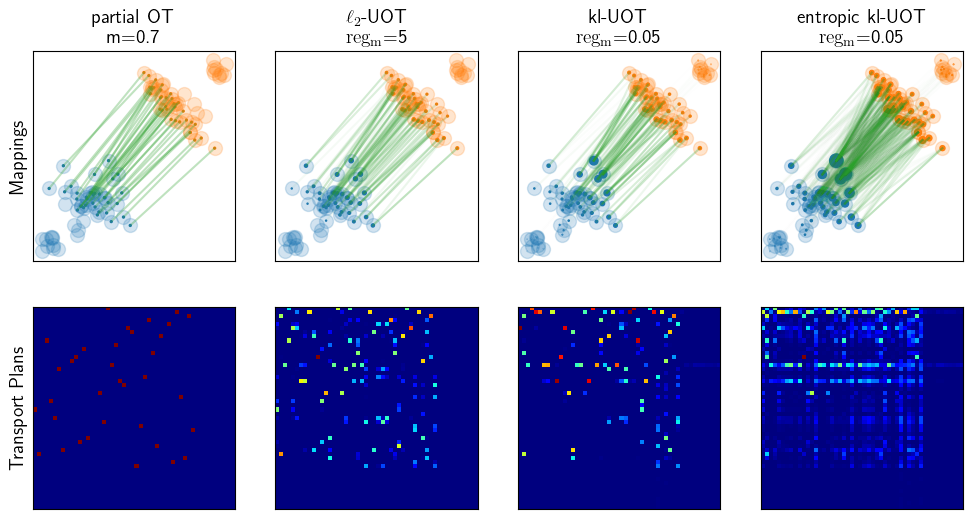

In [11]:
xs, xt = generate_data(N_SAMPLES, MU_S, COV_S, MU_T, COV_T, N_NOISE)
n = N_SAMPLES + N_NOISE
a, b = np.ones((n,)) / n, np.ones((n,)) / n

M = ot.dist(xs, xt)
M /= M.max()

transports = compute_ot_matrices(a, b, M, REG, REG_M_KL, REG_M_L2, MASS)

titles = [
    "partial OT \n m=" + str(MASS),
    "$\ell_2$-UOT \n $\mathrm{reg_m}$=" + str(REG_M_L2),
    "kl-UOT \n $\mathrm{reg_m}$=" + str(REG_M_KL),
    "entropic kl-UOT \n $\mathrm{reg_m}$=" + str(REG_M_KL)
]

plot_results(xs, xt, transports, titles)

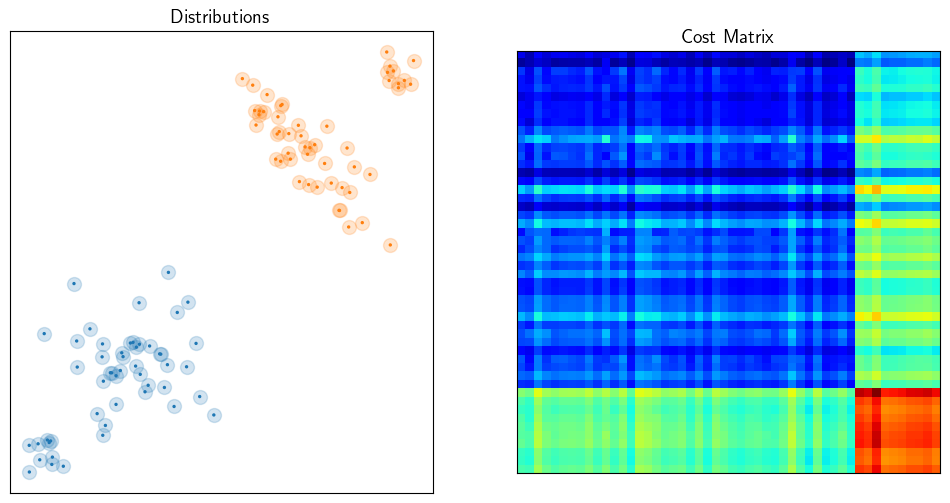

In [13]:
# Make a plot with the distributions
plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(xs[:, 0], xs[:, 1], c='C0', alpha=0.2)
plt.scatter(xt[:, 0], xt[:, 1], c='C1', alpha=0.2)
plt.scatter(xs[:, 0], xs[:, 1], c='C0', s=a * 100)
plt.scatter(xt[:, 0], xt[:, 1], c='C1', s=b * 100)
plt.title("Distributions")
plt.yticks([])
plt.xticks([])
plt.subplot(1, 2, 2)
plt.imshow(M, cmap='jet')
plt.title("Cost Matrix")
plt.yticks([])
plt.xticks([])
plt.savefig("figs/distributions.pdf", bbox_inches='tight')
plt.show()